## Swiss Roll

In [1]:
import numpy as np
import jax
from jax import numpy as jnp

import distrax
import haiku as hk

from ima.upsampling import Pad

from jax.experimental.optimizers import adam

from tqdm import tqdm
from matplotlib import pyplot as plt

/u/shughosh/.local/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '
/u/shughosh/.local/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:
key = jax.random.PRNGKey(1)

## Sources

Text(0.5, 1.0, 'Sources')

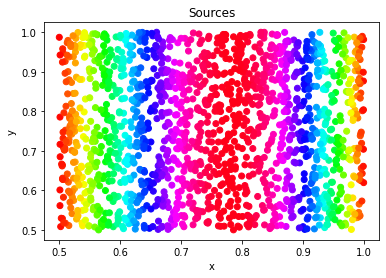

In [4]:
key, subkey = jax.random.split(key)
base_samples = jax.random.uniform(subkey, shape=(1600, 2), minval=0.5, maxval=1.0)
x = base_samples[:,0]
pi = 3.14
idx_col = x*jnp.cos(2*pi*(x) + pi/2)
                    
#base_samples = np.random.uniform(low=4, high=16, size=(1600,2))
plt.scatter(base_samples[:,0], base_samples[:,1], c=idx_col, cmap='hsv')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sources')

## Observations

In [5]:
x = base_samples[:,0]
y = base_samples[:,1]
obs = jnp.stack((x*jnp.cos(2*pi*(x) + pi/2), y, x*jnp.sin(2*pi*(x)+ pi/2)), axis=1)
obs.shape

(1600, 3)

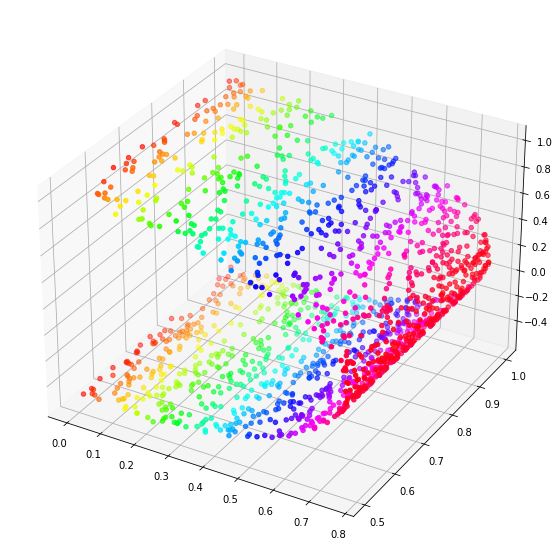

In [6]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection = "3d")
ax.scatter(obs[:,0], obs[:,1], obs[:,2], c=obs[:,0], cmap='hsv')

## Flows

In [7]:
d = 2
D = obs.shape[1]
N = obs.shape[0]

In [8]:
# Define Real NVP flow with Distrax
def mk_flow(K = 2, nl = 8, hu = 256):
    
    layers_lowdim =[]
    for i in range(K):
        mlp = hk.Sequential([hk.nets.MLP(nl * (hu,), activate_final=False),
                             hk.Linear(d, w_init=jnp.zeros, b_init=jnp.zeros)])
        
        def bij_fn_1(params):
            bij = distrax.ScalarAffine(shift=params[..., :d // 2], log_scale=jax.nn.sigmoid(params[..., :d // 2]))
            return distrax.Block(bij, 1)
        
        def bij_fn_2(params):
            if (d % 2):
                bij = distrax.ScalarAffine(shift=params[..., (d // 2) + 1:], log_scale=jax.nn.sigmoid(params[..., (d // 2) + 1:]))
            else:
                bij = distrax.ScalarAffine(shift=params[..., (d // 2):], log_scale=jax.nn.sigmoid(params[..., (d // 2):]))
            return distrax.Block(bij, 1)
        
        if (bool(i%2) == True):
            layers_lowdim.append(distrax.SplitCoupling(d // 2, 1, mlp, bij_fn_2, swap=True))
        else:
            layers_lowdim.append(distrax.SplitCoupling(d // 2, 1, mlp, bij_fn_1, swap=False))
        
        
    flow_lowdim = distrax.Chain(layers_lowdim)
    pad = Pad((0, D - d))
    layers = []
    W = []
    b = []
    for i in range(K):
        
        mlp = hk.Sequential([hk.nets.MLP(nl * (hu,), activate_final=True),
                             hk.Linear(D, w_init=jnp.zeros, b_init=jnp.zeros)])
        
        W.append(hk.get_parameter("W"+ str(i), [D, D], init = jnp.zeros))
        b.append(hk.get_parameter("b"+ str(i), [D], init = jnp.zeros))
        W[i] = W[i] - jnp.diag(jnp.diag(W[i])) + jnp.diag(jnp.exp(jnp.diag(W[i])))
        
        
        
        def bij_fn_1(params):
            bij = distrax.ScalarAffine(shift=params[..., :D // 2], log_scale=params[..., :D // 2])
            return distrax.Block(bij, 1)
        
        def bij_fn_2(params):
            if (D % 2):
                bij = distrax.ScalarAffine(shift=params[..., (D // 2) + 1:], log_scale=params[..., (D // 2) + 1:])
            else:
                bij = distrax.ScalarAffine(shift=params[..., D // 2:], log_scale=params[..., D // 2:])
            return distrax.Block(bij, 1)
        
        if (bool(i%2) == True):
            layers.append(distrax.SplitCoupling(D // 2, 1, mlp, bij_fn_2, swap=True))
        else:
            layers.append(distrax.SplitCoupling(D // 2, 1, mlp, bij_fn_1, swap=False))
        layers.append(distrax.LowerUpperTriangularAffine(matrix = W[i], bias = b[i]))
        
        
    flow = distrax.Chain(layers)
    return (flow_lowdim, pad, flow)

def fwd_(x):
    flow_lowdim, pad, flow = mk_flow()
    x = flow_lowdim.forward(x)
    x = pad.forward(x)
    return flow.forward(x)

def inv_(x):
    flow_lowdim, pad, flow = mk_flow()
    
    x = flow.inverse(x)
    x = pad.inverse(x)
    return flow_lowdim.inverse(x)

In [9]:
D // 2

1

In [10]:
key, subkey = jax.random.split(key)
fwd = hk.transform(fwd_)
inv = hk.transform(inv_)
params = fwd.init(subkey, jnp.array(np.random.randn(5, d)))

## Loss

In [11]:
# Loss function

def loss_(args):
    x, lam, beta, gamma = args
    flow_lowdim, pad, flow = mk_flow()
    
    fwd = lambda y: flow.forward(pad.forward(flow_lowdim.forward(y)))
    inv = lambda y: flow_lowdim.inverse(pad.inverse(flow.inverse(y)))
    fn_inv = lambda y: pad.inverse(flow.inverse(y))
    
    base_dist = distrax.Independent(distrax.Normal(loc=jnp.zeros(d), scale=jnp.ones(d)),
                                    reinterpreted_batch_ndims=1)
    
    jac_fn = jax.vmap(jax.jacfwd(fwd))
    
    z = inv(x)
    fn_inv_obs = fn_inv(x)
    jac = jac_fn(z)
    
    jj = jax.lax.batch_matmul(jnp.transpose(jac, (0, 2, 1)), jac) 
    eye = 0.1*jnp.repeat(jnp.eye(jnp.shape(jj)[1])[jnp.newaxis, :, :], jnp.shape(jj)[0], axis=0)
    jj = jj + eye
     
    chol = jax.vmap(jax.scipy.linalg.cholesky)(jj)
    log_det = jnp.sum(jnp.log(jax.vmap(jnp.diag)(chol)), -1)
    
    
    
    log_det_diag = jnp.sum(jnp.log(jax.vmap(jnp.diag)(jj)), -1)
    
    
    
    
    cima = 0.5*(log_det_diag) - log_det
    diff = jnp.mean((x - fwd(z)) ** 2)
    
    #diff = jnp.mean(jax.vmap(jnp.sqrt)((x - fwd(z)) ** 2))
    
    #import pdb; pdb.set_trace()
    
    return jnp.mean(-lam * (base_dist.log_prob(z) - log_det ) + beta * diff + gamma*cima ), (jnp.mean(-lam * (base_dist.log_prob(z) - log_det)), beta * diff, jnp.mean(gamma*cima)
                                                                                                                    )
    

In [12]:
key, subkey = jax.random.split(key)
loss = hk.transform(loss_)
params = loss.init(subkey, (jnp.array(np.random.randn(5, D)), 1., 1., 1.))

In [13]:
b = jnp.array(np.random.randn(5, D))

In [14]:
loss.apply(params, None, (b, 1., 1., 1,))[1]

(DeviceArray(3.3488023, dtype=float32),
 DeviceArray(0.5413775, dtype=float32),
 DeviceArray(0., dtype=float32))

In [15]:
loss.apply(params, None, (b, 1., 1., 1.))[0]

DeviceArray(3.8901799, dtype=float32)

## Learning

In [16]:
@jax.jit
def step(it_, opt_state_, x_, lam_, beta_, gamma_):
    params_ = get_params(opt_state_)
    
    
    value, grads = jax.value_and_grad(loss.apply, 0, has_aux = True)(params_, None, (x_, lam_, beta_, gamma_))
    opt_state_ = opt_update(it_, grads, opt_state_)
    
    return value, opt_state_, grads, params_

### Configuration

In [17]:
lr = 1e-04

num_iter = 60000
lam_int = [14000, 14001]
batch_size = 1600
beta = 100
gamma_int = [30000, 30001]

loss_hist = np.zeros((0, 2))
loss_manifold_hist = np.zeros((0, 2))
loss_dist_hist = np.zeros((0,2))
loss_cima_hist = np.zeros((0,2))

In [18]:
opt_init, opt_update, get_params = adam(step_size=lr)
opt_state = opt_init(params)

In [19]:
observations = obs
for it in tqdm(range(num_iter)):
    x = observations[np.random.choice(N, batch_size)]
    
    # Need to warm up lambda due to stability issues
    lam = np.interp(it, lam_int, [0, 1])
    gam = np.interp(it, gamma_int, [0, 200])
    
    loss_val, opt_state, grads, params_learned = step(it, opt_state, x, lam, beta, gam)
    
    
    loss_append = np.array([[it + 1, loss_val[0].item()]])
    loss_manifold_append = np.array([[it + 1, loss_val[1][1].item()]])
    loss_dist_append = np.array([[it + 1, loss_val[1][0].item()]])
    loss_cima_append = np.array([[it + 1, loss_val[1][2].item()]])

    loss_hist = np.concatenate([loss_hist, loss_append])
    loss_manifold_hist = np.concatenate([loss_manifold_hist, loss_manifold_append])
    loss_dist_hist = np.concatenate([loss_dist_hist, loss_dist_append])
    loss_cima_hist = np.concatenate([loss_cima_hist, loss_cima_append])
    
    if (it == lam_int[0]):
        params_manifold = params_learned
    if (it == gamma_int[1]):
        params_dist = params_learned
        
    


100%|█████████████████████████████████████| 60000/60000 [12:44<00:00, 78.49it/s]


## Results

### Complete loss

In [20]:
loss_hist

array([[1.00000000e+00, 9.75736427e+00],
       [2.00000000e+00, 1.03407907e+01],
       [3.00000000e+00, 9.91095161e+00],
       ...,
       [5.99980000e+04, 1.42133582e+00],
       [5.99990000e+04, 1.43793666e+00],
       [6.00000000e+04, 1.38913798e+00]])

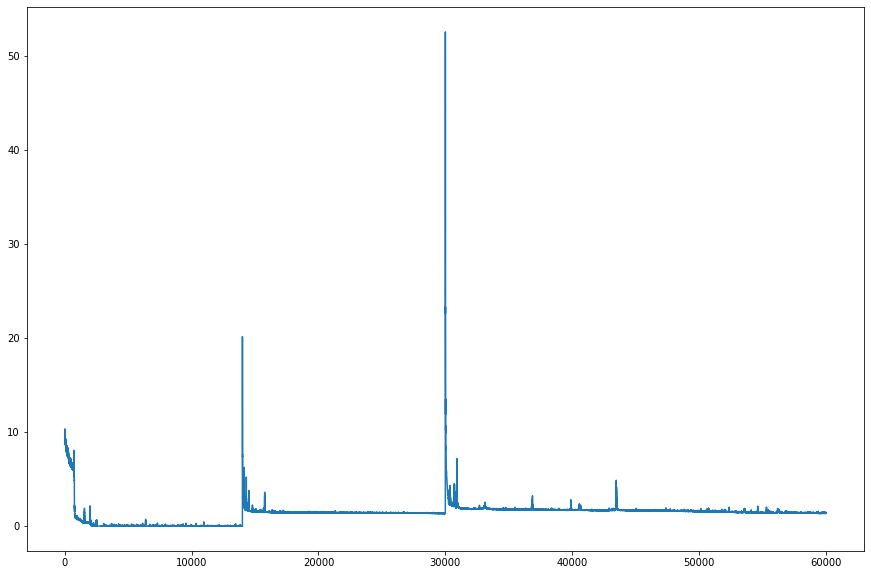

In [21]:
plt.figure(figsize=(15, 10))
plt.plot(loss_hist[:, 0], loss_hist[:, 1])
plt.show()

### Manifold loss

In [22]:
loss_manifold_hist

array([[1.00000000e+00, 9.75736523e+00],
       [2.00000000e+00, 1.03407917e+01],
       [3.00000000e+00, 9.91095257e+00],
       ...,
       [5.99980000e+04, 9.51796398e-02],
       [5.99990000e+04, 1.14638217e-01],
       [6.00000000e+04, 5.02278432e-02]])

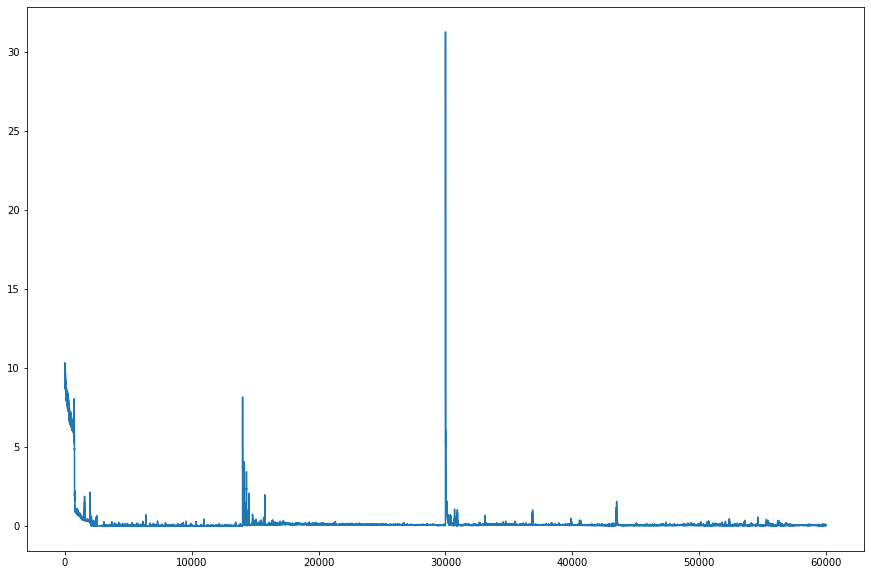

In [23]:
plt.figure(figsize=(15, 10))
plt.plot(loss_manifold_hist[:, 0], loss_manifold_hist[:, 1])
plt.show()

In [24]:
sources_in = inv.apply(params_manifold, None, obs)
mani_out = fwd.apply(params_manifold, None, sources_in)

Text(0.5, 1.0, 'Sources')

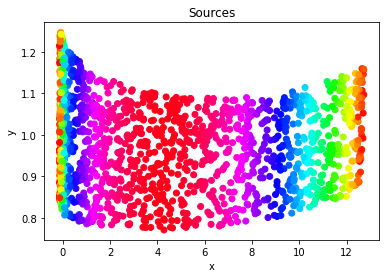

In [25]:
plt.scatter(sources_in[:,0], sources_in[:,1], c=obs[:,0], cmap='hsv')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sources')

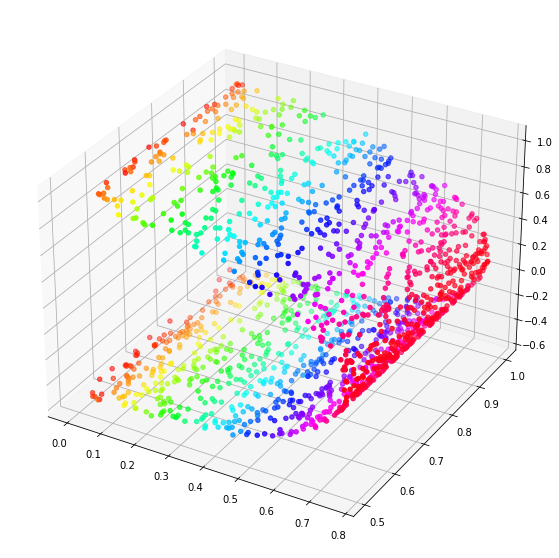

In [26]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection = "3d")

ax.scatter(mani_out[:,0], mani_out[:,1], mani_out[:,2], c=obs[:,0], cmap='hsv')

### Distribution loss

In [27]:
loss_dist_hist

array([[1.00000000e+00, 0.00000000e+00],
       [2.00000000e+00, 0.00000000e+00],
       [3.00000000e+00, 0.00000000e+00],
       ...,
       [5.99980000e+04, 1.27793896e+00],
       [5.99990000e+04, 1.26175201e+00],
       [6.00000000e+04, 1.27290070e+00]])

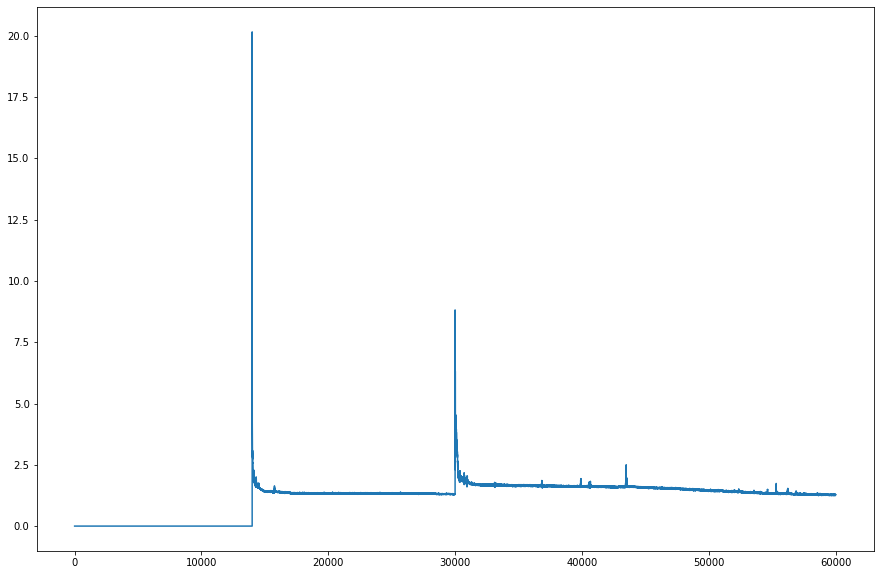

In [28]:
plt.figure(figsize=(15, 10))
plt.plot(loss_dist_hist[:, 0], loss_dist_hist[:, 1])
plt.show()

In [29]:
sources_in = inv.apply(params_dist, None, obs)
mani_out = fwd.apply(params_dist, None, sources_in)

Text(0.5, 1.0, 'Sources')

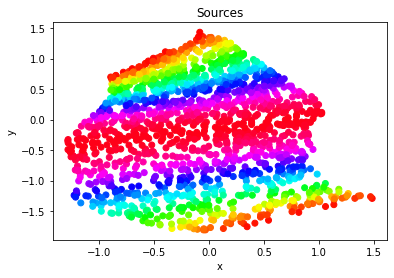

In [30]:
plt.scatter(sources_in[:,0], sources_in[:,1], c=obs[:,0], cmap='hsv')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sources')

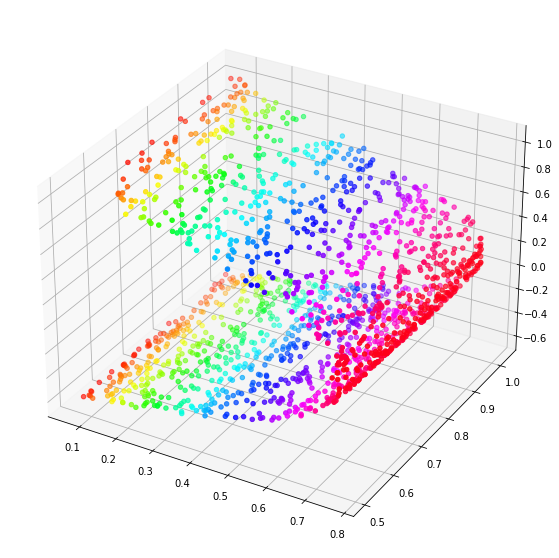

In [31]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection = "3d")

ax.scatter(mani_out[:,0], mani_out[:,1], mani_out[:,2], c=obs[:,0], cmap='hsv')

### Cima loss

In [32]:
loss_cima_hist

array([[1.00000000e+00, 0.00000000e+00],
       [2.00000000e+00, 0.00000000e+00],
       [3.00000000e+00, 0.00000000e+00],
       ...,
       [5.99980000e+04, 4.82173152e-02],
       [5.99990000e+04, 6.15464561e-02],
       [6.00000000e+04, 6.60093650e-02]])

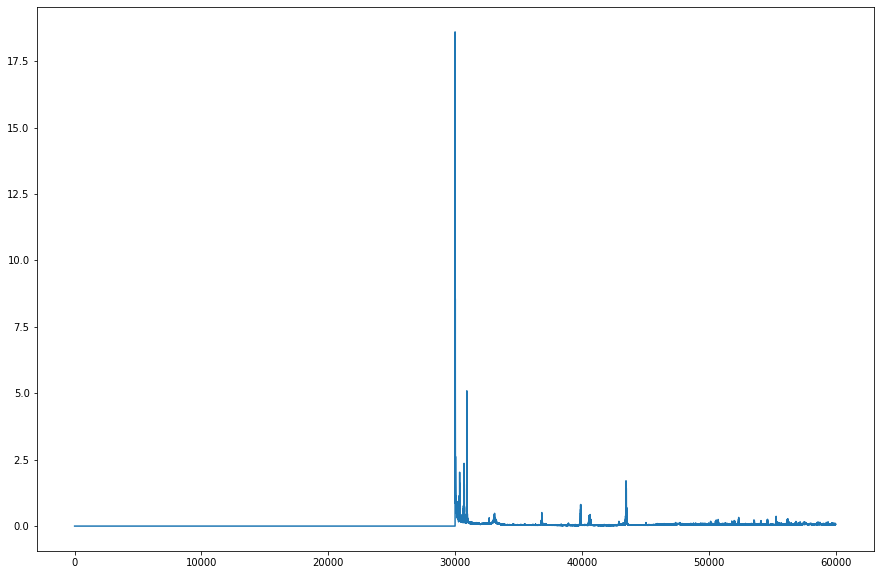

In [33]:
plt.figure(figsize=(15, 10))
plt.plot(loss_cima_hist[:, 0], loss_cima_hist[:, 1])
plt.show()

In [34]:
sources_in = inv.apply(params_learned, None, obs)
mani_out = fwd.apply(params_learned, None, sources_in)

Text(0.5, 1.0, 'Sources')

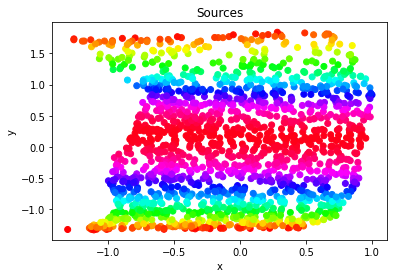

In [35]:
plt.scatter(sources_in[:,0], sources_in[:,1], c=obs[:,0], cmap='hsv')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sources')

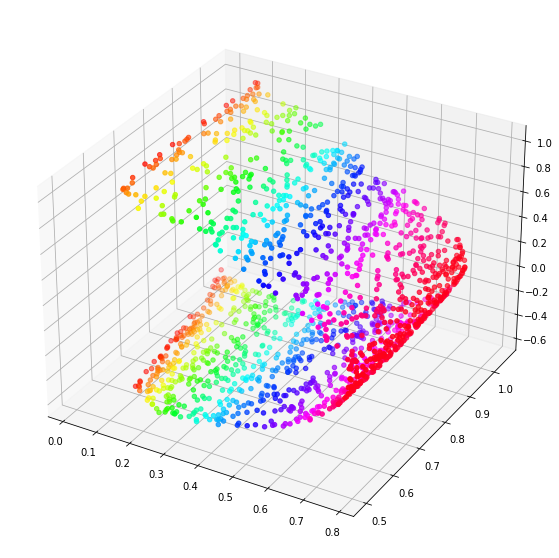

In [36]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection = "3d")

ax.scatter(mani_out[:,0], mani_out[:,1], mani_out[:,2], c=obs[:,0], cmap='hsv')

## Notes

### Objectives:

1. To check if Cima gives unmixed sources -- observed through colour plots and MCC

### Observations:

1. Cima seems to have unmixing effect relative to sources learned
2. Cima loss reduces very fast (potentially strange?)

### Questions:

1. Are we at optimal values for distribution (log-likelihood) and cima loss? What are the potential checks?


### TODOs:

1. Add MCC computation
2. Modify colour coding so that we have better visualization of unmixing (with current colour coding, cannot really say if just optimizing manifold loss leads to mixed sources)
3. Optimize lambda, beta, gamma (multiplocative coeffs for dist, manifold, cima)
4. Use complete swiss roll

## Meeting Notes 25.04.2022

### Action points:

1. Base dist: Hypersecant or logistic instead of normal
2. Correct element-wise nonlinearities to a uniform distribution using CDF transform
3. Compute MCC (want to show: MCC higher if you include cima loss)
4. Grid search on Lagrangian multipliers (gamma: 0.1, 1, 10, 100, beta: change scales?)
5. Remove spikes in plots
6. Write down part about behaviour of IMA (lambda < 1, =1, >1), and justify with experiments in thesis document -- Cima loss converging very fast
7. Check optimal value for log-likelihood by computing
8. Metrics on quality of manifold learning -- MSE loss
9. Metrics from Cian's paper in high-dimensional case -- completeness, how many dimensions recovered